In [1]:
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import rospy
from geometry_msgs.msg import PoseStamped
import matplotlib.pyplot as plt
from cv_bridge import CvBridge, CvBridgeError
from sensor_msgs.msg import Image

In [2]:
lst=[]
threshold = 0.4
model = torch.hub.load('ultralytics/yolov5', 'custom','/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/yolov5/runs/train/yolov5s_ODD_results2/weights/best.pt', force_reload=True)


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/omar/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-5-14 Python-3.8.10 torch-2.2.2+cu121 CPU

Fusing layers... 
YOLOv5m summary: 212 layers, 20893344 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


In [3]:
model_instance = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s-seg.pt')

Using cache found in /home/omar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-14 Python-3.8.10 torch-2.2.2+cu121 CPU

100%|██████████| 14.9M/14.9M [02:23<00:00, 108kB/s] 

Fusing layers... 
YOLOv5s-seg summary: 224 layers, 7611485 parameters, 0 gradients, 26.4 GFLOPs
WARNING ⚠️ YOLOv5 SegmentationModel is not yet AutoShape compatible. You will not be able to run inference with this model.


# Segmentation

In [ ]:
import cv2

# Read the image
img = cv2.imread('/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/number_data/depthhhh.png')
# Perform detection and segmentation
results = model(img)

# Extract masks and bounding boxes
masks = results.pred[0][:, -1]  # mask data
boxes = results.pred[0][:, :4]  # bounding box data


In [ ]:
import numpy as np

def mask_numbers(image, masks, boxes, class_ids, number_class_index):
    for i, box in enumerate(boxes):
        if class_ids[i] == number_class_index:
            x1, y1, x2, y2 = map(int, box)
            mask = masks[i].cpu().numpy()
            mask_resized = cv2.resize(mask, (x2 - x1, y2 - y1))
            mask_binary = (mask_resized > 0.5).astype(np.uint8) * 255
            
            # Create a mask of the same size as the image
            full_mask = np.zeros_like(image, dtype=np.uint8)
            full_mask[y1:y2, x1:x2] = mask_binary[..., np.newaxis]

            # Apply the mask to the image
            image[full_mask > 0] = [255, 255, 255]
    return image

# Get class IDs
class_ids = results.pred[0][:, 5].cpu().numpy().astype(int)

# Define the class index for numbers (you need to know the class index for numbers in your dataset)
NUMBER_CLASS_INDEX = 0  # Replace with the correct class index

# Apply masks to the image
masked_img = mask_numbers(img.copy(), masks, boxes, class_ids, NUMBER_CLASS_INDEX)

# Save the masked image
cv2.imwrite('masked_image.jpg', masked_img)


# Normal Detection

In [ ]:
img = cv2.imread('/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/number_data/depthhhh.png')

In [3]:
results =model(img)
filtered_results = results.xyxy[0][results.xyxy[0][:, 4] >= threshold]


tensor([[388.79691,  22.99566, 423.49411,  69.57364,   0.85803,   6.00000],
        [387.40530, 384.69864, 425.43619, 431.27426,   0.84440,   4.00000],
        [144.84663, 384.19168, 185.61592, 429.93283,   0.84077,   9.00000],
        [156.13968,  21.97688, 178.25153,  68.91460,   0.80972,   1.00000]])


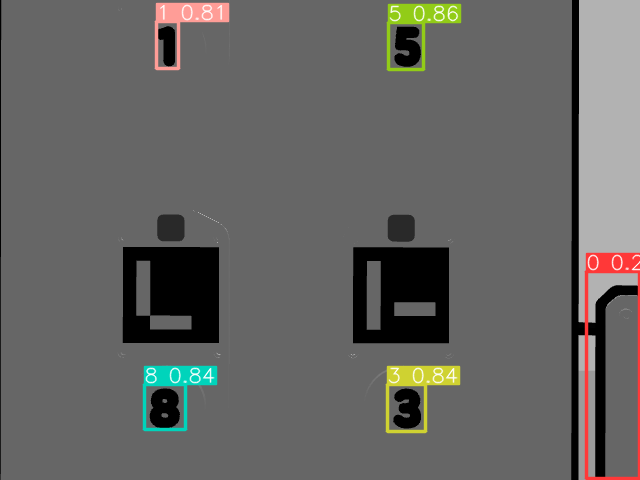

image 1/1: 480x640 1 0, 1 1, 1 3, 1 5, 1 8
Speed: 494.9ms pre-process, 306.6ms inference, 283.2ms NMS per image at shape (1, 3, 480, 640)


In [4]:
# Print filtered results
print(filtered_results)
# Results
results.show()
print(results)


In [5]:

for item in results.xyxy[0]:  # Iterate through the results objects
    class_id = item[-1]  # Get the class ID
    class_name = model.names[int(class_id)]  # Get the class name using class ID
    print(class_name)


5
3
8
1
0


In [6]:
filtered_results.shape[0]

4

In [9]:
def draw_center(label_results , class_name):

    x,y,h,w = label_results[class_name][0][0] , label_results[class_name][0][1] , label_results[class_name][0][2] , label_results[class_name][0][3]


    new_image=cv2.imread('/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/number_data/depthhhh.png')
    center_x = int((x + h) / 2)
    center_y = int((y + w) / 2)
    center = (center_x,center_y)

    cv2.circle(new_image, (center_x, center_y), 5, (255, 255, 255), -1)
    cv2.imwrite(f'/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/yolov5/Centers/{class_name}_center.jpg', new_image)
    return center

In [13]:
label_results = {}
label_with_coordinates = {}
# Iterate through the filtered results
for item in results.xyxy[0][results.xyxy[0][:, 4] >= threshold]:  
    class_id = int(item[-1])  # Get the class ID
    class_name = model.names[class_id]  # Get the class name using class ID
    
    # If the class name is not in the dictionary, add it as a key with an empty list
    if class_name not in label_results:
        label_results[class_name] = []
        label_with_coordinates[class_name] = []  # Initialize empty list for centers

    # Append the result tensor to the list corresponding to the class name
    label_results[class_name].append(item)
    center = draw_center(label_results,class_name)
    # print(center)
    label_with_coordinates[class_name].append(center)
# Print the dictionary
print(label_results)
print(label_with_coordinates)

{'5': [tensor([388.79691,  22.99566, 423.49411,  69.57364,   0.85803,   6.00000])], '3': [tensor([387.40530, 384.69864, 425.43619, 431.27426,   0.84440,   4.00000])], '8': [tensor([144.84663, 384.19168, 185.61592, 429.93283,   0.84077,   9.00000])], '1': [tensor([156.13968,  21.97688, 178.25153,  68.91460,   0.80972,   1.00000])]}
{'5': [(406, 46)], '3': [(406, 407)], '8': [(165, 407)], '1': [(167, 45)]}


In [14]:
label_with_coordinates

{'5': [(406, 46)], '3': [(406, 407)], '8': [(165, 407)], '1': [(167, 45)]}

# Getting Mask of the detected object

In [1]:
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:

threshold = 0.4
model = torch.hub.load('ultralytics/yolov5', 'custom','/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/yolov5/runs/train/yolov5s_ODD_results2/weights/best.pt', force_reload=True)

results =model('/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/number_data/depthhhh.png')
filtered_results = results.xyxy[0][results.xyxy[0][:, 4] >= threshold]


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/omar/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-5-13 Python-3.8.10 torch-2.2.2+cu121 CPU

Fusing layers... 
YOLOv5m summary: 212 layers, 20893344 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


tensor([[388.79691,  22.99566, 423.49411,  69.57364,   0.85803,   6.00000],
        [387.40530, 384.69864, 425.43619, 431.27426,   0.84440,   4.00000],
        [144.84663, 384.19168, 185.61592, 429.93283,   0.84077,   9.00000],
        [156.13968,  21.97688, 178.25153,  68.91460,   0.80972,   1.00000]])


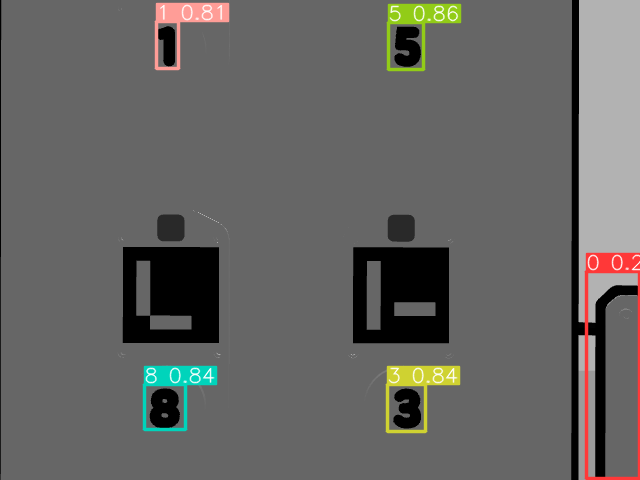

image 1/1: 480x640 1 0, 1 1, 1 3, 1 5, 1 8
Speed: 8.6ms pre-process, 198.9ms inference, 0.9ms NMS per image at shape (1, 3, 480, 640)


In [3]:
results =model('/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/number_data/depthhhh.png')
filtered_results = results.xyxy[0][results.xyxy[0][:, 4] >= threshold]
# Print filtered results
print(filtered_results)
# Results
results.show()
print(results)


In [4]:

for item in results.xyxy[0]:  # Iterate through the results objects
    class_id = item[-1]  # Get the class ID
    class_name = model.names[int(class_id)]  # Get the class name using class ID
    print(class_name)


5
3
8
1
0


In [5]:
def draw_center(label_results , class_name):

    x,y,h,w = label_results[class_name][0][0] , label_results[class_name][0][1] , label_results[class_name][0][2] , label_results[class_name][0][3]


    new_image=cv2.imread('/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/number_data/depthhhh.png')
    center_x = int((x + h) / 2)
    center_y = int((y + w) / 2)
    center = (center_x,center_y)

    cv2.circle(new_image, (center_x, center_y), 5, (255, 255, 255), -1)
    cv2.imwrite(f'/home/omar/RobotArmPerception/cameraSim/src/arm_urdf/yolov5/Centers/{class_name}_center.jpg', new_image)
    return center

In [6]:
label_results = {}
label_with_coordinates = {}
# Iterate through the filtered results
for item in results.xyxy[0][results.xyxy[0][:, 4] >= threshold]:  
    class_id = int(item[-1])  # Get the class ID
    class_name = model.names[class_id]  # Get the class name using class ID
    
    # If the class name is not in the dictionary, add it as a key with an empty list
    if class_name not in label_results:
        label_results[class_name] = []
        label_with_coordinates[class_name] = []  # Initialize empty list for centers

    # Append the result tensor to the list corresponding to the class name
    label_results[class_name].append(item)
    center = draw_center(label_results,class_name)
    # print(center)
    label_with_coordinates[class_name].append(center)
# Print the dictionary
print(label_results)
print(label_with_coordinates)

{'5': [tensor([388.79691,  22.99566, 423.49411,  69.57364,   0.85803,   6.00000])], '3': [tensor([387.40530, 384.69864, 425.43619, 431.27426,   0.84440,   4.00000])], '8': [tensor([144.84663, 384.19168, 185.61592, 429.93283,   0.84077,   9.00000])], '1': [tensor([156.13968,  21.97688, 178.25153,  68.91460,   0.80972,   1.00000])]}
{'5': [(406, 46)], '3': [(406, 407)], '8': [(165, 407)], '1': [(167, 45)]}
